In [2]:
import os
import keras
#https://github.com/fizyr/keras-retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

Using TensorFlow backend.


# UTILITY FUNCTIONS

In [0]:

def read_img(imfile):
    
    import cv2
    
    return cv2.imread(imfile)[:,:,::-1]
  
def read_boxes(txtfile):

    import numpy as np
    lines = []

    with open(txtfile, "r") as f:

        for line in f:
            line = line.strip()
            box = np.hstack(line.split()).astype(np.float)
            box[0] = int(box[0])
            lines.append(box)

    return np.array(lines)


def yolo2voc(boxes, imshape):
    
    import numpy as np 
    m, n = imshape[:2]
    
    box_list = []
    for b in boxes:
        cls, x, y, w, h = b
        
        x1 = (x-w/2.)
        x2 = x1 + w
        y1 = (y-h/2.)
        y2 = y1 + h
        
        # absolute:
        x1 = x1 * n ; x2 = x2*n
        y1 = y1 * m ; y2 = y2*m
        
        box_list.append([cls, x1,y1,x2,y2])
    
    if len(box_list)>0:
        box_list = np.vstack(box_list)
        
    return box_list


def plot_boxes(ax, boxes, labels):
    
    import seaborn as sns 
    
    color_pal = sns.color_palette('hls', n_colors = len(labels))
    
    for b in boxes:
        cls, x1, y1, x2, y2 = b
        ax.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1],lw=2, color=color_pal[int(cls)])
        
    return []

def read_tiff(filename):
    from skimage.external.tifffile import TiffFile
    with TiffFile(filename) as tif:
      data = tif.asarray()
    return data

def read_obj_names(textfile):
    
    import numpy as np 
    classnames = []
    
    with open(textfile) as f:
        for line in f:
            line = line.strip('\n')
            if len(line)>0:
                classnames.append(line)
            
    return np.hstack(classnames)



# LOAD MODEL

In [ ]:
model_path = "resnet152_csv_05_inference.h5"
# load retinanet model

model = models.load_model(model_path, backbone_name='resnet152')
labels_to_names={0:'specularity', 1: 'saturation', 2: 'artifact',3: 'blur', 4: 'contrast',5: 'bubbles',6: 'instrument'}

# APPLY THE NETWORK

processing time:  5.665721893310547


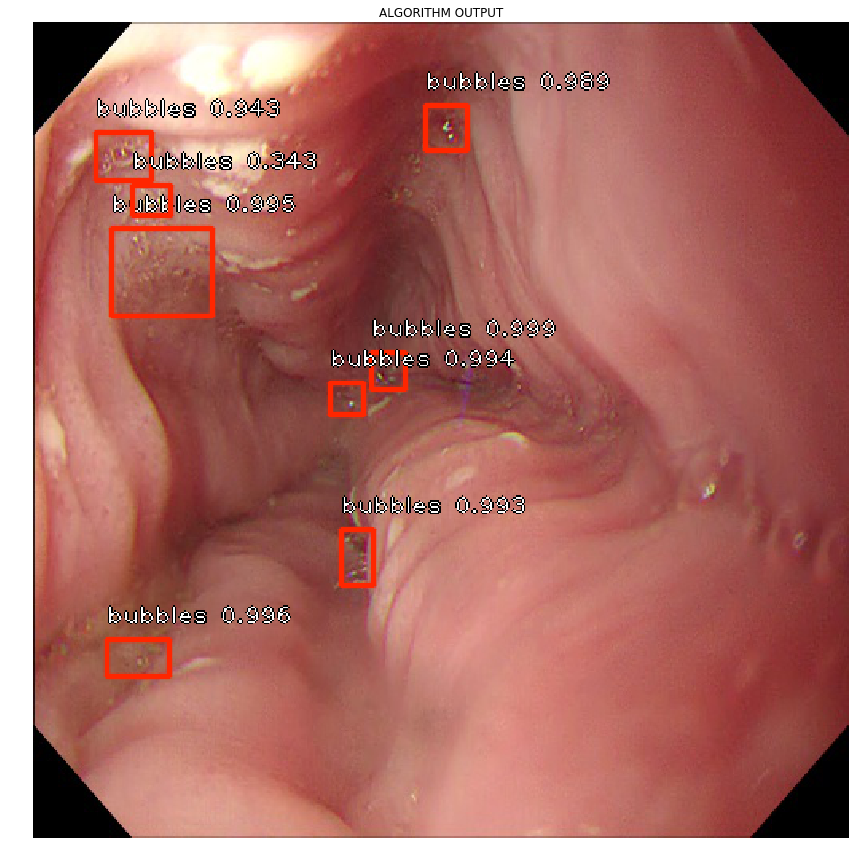

In [7]:
TH=0.2# Confidence threshold to save

filename="00003.jpg"
resultname="00003_algo_result.txt" # Filename to save the results in .txt file
figname="00003_algo_result.png" # Filepath to save the results of the algorithm

image = read_image_bgr(filename)
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# SAVE .TXT FILE
scores1=np.squeeze(scores,axis=0)
scoresind=np.argwhere(scores1 > TH) 
scoresind=np.squeeze(scoresind)

boxes1=boxes[0,:,:].astype(float)


scores11=np.zeros((scores.shape[1],1))
scores11[:,0]=scores[0,:]
labels11=np.zeros((scoresind.size,1),dtype='U16')
for i in range(0,scoresind.size):
  labels11[i,0]=labels_to_names[labels[0,i]]



if scoresind.size==1:
  scores11a=scores11[scoresind,:].reshape(1,scores11[scoresind,:].shape[0]) 
  boxes1a=boxes1[scoresind,:].reshape(1,boxes1[scoresind,:].shape[0])
  scores2=np.hstack((labels11,scores11a,boxes1a))
else:
  scores2=np.hstack((labels11,scores11[scoresind,:],boxes1[scoresind,:]))

  
np.savetxt(resultname,scores2,fmt= '%s %s %s %s %s %s' )


# VISUALIZATION

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < TH:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    #print(labels_to_names[label])

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.title('ALGORITHM OUTPUT')
plt.savefig(figname,dpi=600) 



# GROUND TRUTH

Text(0.5, 1.0, 'GROUND TRUTH')

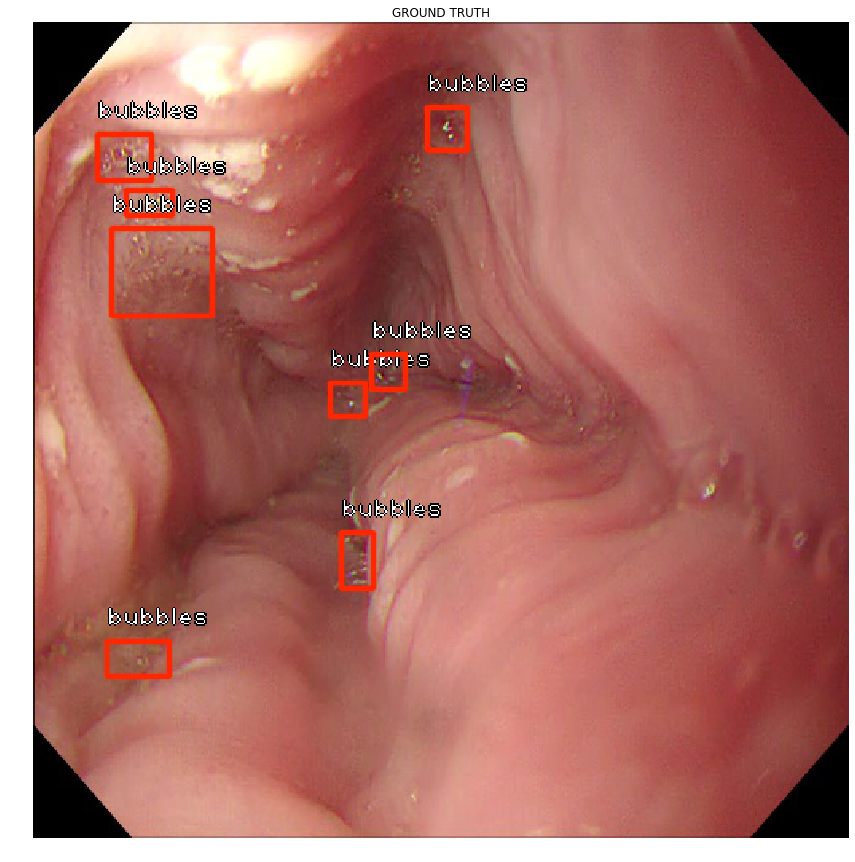

In [8]:
imgfile="/content/drive/My Drive/EAD2019/EAD2019/annotationImages_and_labels/00003.jpg"
bboxfile = "/content/drive/My Drive/EAD2019/EAD2019/annotationImages_and_labels/00003.txt"


classfile = '/content/drive/My Drive/EAD2019/EAD2019/class_list.txt'
classes = read_obj_names(classfile)

img = read_img(imgfile)
boxes = read_boxes(bboxfile)

# convert boxes from (x,y,w,h) to (x1,y1,x2,y2) format for plotting
boxes_abs = yolo2voc(boxes, img.shape)

image = read_image_bgr(imgfile)
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

for box, label in zip(boxes_abs[:,1:], labels[0]):
    # scores are sorted so we can break

    color = label_color(label)
    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{}".format(labels_to_names[label])
    draw_caption(draw, b, caption)
    


plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.title('GROUND TRUTH')
